# Lab 7

**Author: Skorik Sergey**

## The Task

Consider [Hinton](https://arxiv.org/pdf/1503.02531.pdf) distillation, but without dataset labels (only teacher output for distillation).
Dataset: MNIST. Consider case, when we have two teacher trained only on class subsets (0,..,4) and (5,..,9): Loss = lambda * Dist_1 + (1-lambda) * Dist_2

Visualize accuracy of the model with 3 axes:

* Accuracy
* Temperature
* Lambda


## Theory

Considering Hinton distillation with objective:

$$Dist = \eta\log p \left[y \mid SM(f_{student}(X) / T) \right] + (1 - \eta) \log p \left[SM(f_{teacher}(X) / T) \mid SM(f_{student}(X) / T) \right]$$
We consider the case without dataset hard labels, so, the objective:
$$Dist = \log p \left[SM(f_{teacher}(X) / T) \mid SM(f_{student}(X) / T) \right] $$
We also consider two teachers, trained only on class subsets $(0, \ldots, 4)$ and $(5, \ldots, 9)$. The distilled model objective
$$\mathcal{L}(\lambda, T) = \lambda \cdot Dist_1(T) +  (1 - \lambda) \cdot Dist_2(T)$$ 
Where $Dist_i(T)$ is defined above, $i=\overline{1,2}$. 

Thus, experiment consist of following steps:
* Train teacher models on subclasses.
* Distill student model with different $\lambda$, $T$ on a whole dataset.
* Make a plot dependency of accuracy.

## Experiment

### Imports

In [66]:
## JAX imports
import jax
import jax.numpy as jnp
from jax import random, jit
from jax.tree_util import Partial

import numpy as np

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training.train_state import TrainState

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## import tensorflow dataset
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

##Logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Load data

In [2]:
data_dir = '/tmp/tfds/'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
X_train, y_train = train_data['image'], train_data['label']
X_train = jnp.reshape(X_train, (len(X_train), num_pixels))

# Full test set
X_test, y_test = test_data['image'], test_data['label']
X_test = jnp.reshape(X_test, (len(X_test), num_pixels))

# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
ids_train = np.random.choice(X_train.shape[0], size=(X_train.shape[0]))
ids_val = np.random.choice(X_val.shape[0], size=(X_val.shape[0]))

X_train, X_val, y_train, y_val = X_train[ids_train], X_val[ids_val], y_train[ids_train], y_val[ids_val]

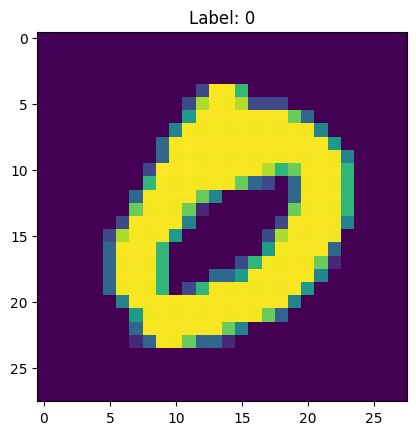

In [4]:
plt.imshow(X_train[0].reshape(28, 28))
plt.title(f"Label: {y_train[0]}")
plt.show()

In [5]:
X_train[0].shape

(784,)

In [6]:
## Make a subclasses

def make_subclass(X, y, subset):
    sub_ids = [i for i, label in enumerate(y) if label in subset]
    return X[sub_ids], y[sub_ids]

subset_1 = [0, 1, 2, 3, 4]
subset_2 = [5, 6, 7, 8, 9]

sub_1_X_train, sub_1_y_train = make_subclass(X_train, y_train, subset_1)
sub_1_X_val, sub_1_y_val = make_subclass(X_val, y_val, subset_1)

sub_2_X_train, sub_2_y_train = make_subclass(X_train, y_train, subset_2)
sub_2_X_val, sub_2_y_val = make_subclass(X_val, y_val, subset_2)

In [7]:
print(f"Train subclass [0...4] size: {len(sub_1_y_train)}")
print(f"Train subclass [5...9] size: {len(sub_2_y_train)}")

Train subclass [0...4] size: 24591
Train subclass [5...9] size: 23409


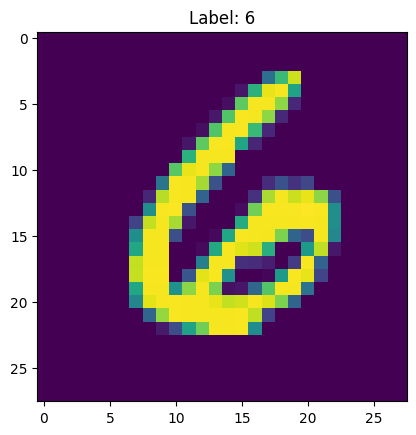

In [8]:
plt.imshow(sub_2_X_train[15].reshape(28, 28))
plt.title(f"Label: {sub_2_y_train[15]}")
plt.show()

In [9]:
# we need to perfom subclass 2 targets to [0...4] range for correct one_hot encoding
sub_2_y_train = [i-5 for i in sub_2_y_train]
sub_2_y_val = [i-5 for i in sub_2_y_val]

### Pipeline

In [11]:
class MLP(nn.Module):
    hiddens: list
    model_type: str

    @nn.compact
    def __call__(self, x, train=True):
        for hidden_size in self.hiddens:
            x = nn.Dense(hidden_size)(x)
            if self.model_type == 'teacher':
                x = nn.Dropout(0.5)(x, deterministic=not train)
            x = nn.relu(x)
        if self.model_type == 'teacher':
            output = 5
        else:
            output = 10
        return nn.Dense(output)(x)

In [12]:
def create_train_state(rng, tx, hiddens, model_type):
    """Creates initial `TrainState`."""
    model = MLP(hiddens, model_type)
    if model_type == 'teacher':
        rng = {'params': rng[0], 'dropout': rng[1]}
    params = model.init(rng, jnp.ones(shape=X_train[0].shape))['params'] # initialize parameters by passing a template input
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [55]:
@jax.jit
def teacher_loss(logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=5)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

@Partial(jit, static_argnames=('T', 'slc'))
def distillation(tLogits, sLogits, T, slc):
    s_lsm = nn.activation.log_softmax(sLogits / T)
    t_lsm = nn.activation.softmax(tLogits / T)
    if slc == 'first':
        s_lsm = s_lsm[:, :5]
    else:
        s_lsm = s_lsm[:, 5:]
    return -jnp.sum(s_lsm*t_lsm, axis=-1).mean()

@Partial(jit, static_argnames=('alpha', 'T'))
def student_loss(sLogits, t1Logits, t2Logits, alpha, T):
    return alpha * distillation(t1Logits, sLogits, T, 'first') + (1 - alpha) * distillation(t2Logits, sLogits, T, 'second')

@Partial(jit, static_argnames=('objective', 'alpha', 'T'))
def call_objective(logits, labels, objective, alpha, T):
    if objective == 'teacher_loss':
        loss = teacher_loss(logits, labels)
    elif objective == 'student_loss':
        assert alpha is not None and T is not None
        t1Logits, t2Logits = labels
        loss = student_loss(logits, t1Logits, t2Logits, alpha, T)
    return loss

@Partial(jit, static_argnames=('objective', 'alpha', 'T'))
def train_step(state, input, labels, objective, alpha, T):
    def loss_f(params):
        logits = state.apply_fn({'params': params}, input, rngs={'dropout': random.PRNGKey(42)})
        return call_objective(logits, labels, objective, alpha, T)
    grad_fn = jax.value_and_grad(loss_f)
    loss, grads = grad_fn(state.params)
    # print(f"grads:{grads}")
    # print(f"train_loss: {loss}")
    state = state.apply_gradients(grads=grads)
    return state, loss

@Partial(jit, static_argnames=('objective', 'alpha', 'T'))
def validate(X_val, y_val, state, objective, alpha, T):
    logits = state.apply_fn({'params': state.params}, X_val, train=False)
    return call_objective(logits, y_val, objective, alpha, T)

def train_epoch(state, epoch, X_train, y_train, bs, objective, alpha, T):
    """Train for a single epoch."""
    train_loss = []
    # print(f"Dataset len: {X_train.shape[0]}")
    for it in range(X_train.shape[0] // bs):
        input = X_train[it*bs:(it+1)*bs]
        if alpha is not None and T is not None:
            labels_1 = y_train[0][it*bs:(it+1)*bs]
            labels_2 = y_train[1][it*bs:(it+1)*bs]
            labels = [labels_1, labels_2]
        else:
            labels = y_train[it*bs:(it+1)*bs]
        state, loss = train_step(state, input, labels, objective, alpha, T)
        train_loss.append(loss.item())
        if it == 3:
            break
    return state, train_loss

def train_model(X_train, y_train, X_test, y_test, state, objective, batch_size=32, epochs=100, epochs_no_improve=10, alpha=None, T=None):
    best_loss = jnp.inf
    best_model = None
    patience = 0
    train_losses = []
    for epoch in tqdm(range(epochs)):
        # print("I'm here")
        state, train_loss = train_epoch(state, epoch, X_train, y_train, batch_size, objective, alpha, T)
        validate_loss = validate(X_test, y_test, state, objective, alpha, T)
        train_losses.extend(train_loss)
        if validate_loss < best_loss:
            best_loss = validate_loss
            best_model = state.params
            patience = 0
        if patience == epochs_no_improve:
            print("Early stopping")
            return best_model, train_losses, best_loss
        # break
        patience += 1
    return best_model, train_losses, best_loss

def calculate_acc(params, hidden, x, y, model_type):
    model = MLP(hidden, model_type)
    preds = nn.activation.softmax(model.apply({'params': params}, x, train=False))
    ids = jnp.argmax(preds, axis=-1)
    return jnp.mean(ids == y)

### Training teacher models

In [34]:
#Initialize teacher models state
state_1 = create_train_state([random.PRNGKey(0), random.PRNGKey(1)], optax.adam(1e-3), [1200, 1200], model_type='teacher')
state_2 = create_train_state([random.PRNGKey(2), random.PRNGKey(3)], optax.adam(1e-3), [1200, 1200], model_type='teacher')

In [35]:
# Teacher_1 training
best_params_1, train_loss_1, val_loss_1 = train_model(sub_1_X_train, sub_1_y_train, sub_1_X_val, sub_1_y_val, state_1, objective='teacher_loss', batch_size=128)

 12%|█▏        | 12/100 [00:02<00:14,  5.95it/s]

Early stopping


In [36]:
# Teacher_2 training
best_params_2, train_loss_2, val_loss_2 = train_model(sub_2_X_train, sub_2_y_train, sub_2_X_val, sub_2_y_val, state_2, objective='teacher_loss', batch_size=128)

 43%|████▎     | 43/100 [00:29<00:39,  1.44it/s]

Early stopping


In [38]:
# Teacher models testing
sub_1_X_test, sub_1_y_test = make_subclass(X_test, y_test, subset_1)
sub_2_X_test, sub_2_y_test = make_subclass(X_test, y_test, subset_2)
sub_2_y_test = jnp.array([i-5 for i in sub_2_y_test])

print(f"Teacher 1 test acc: {calculate_acc(best_params_1, [1200, 1200], sub_1_X_test, sub_1_y_test, model_type='teacher')}")
print(f"Teacher 2 test acc: {calculate_acc(best_params_2, [1200, 1200], sub_2_X_test, sub_2_y_test, model_type='teacher')}")

Teacher 1 test acc: 0.9237205982208252
Teacher 2 test acc: 0.8932318091392517


In [41]:
# Make a soft labels

model = MLP([1200, 1200], 'teacher')

t1Logits_train = model.apply({'params': best_params_1}, X_train, train=False)
t2Logits_train  = model.apply({'params': best_params_2}, X_train, train=False)

t1Logits_val = model.apply({'params': best_params_1}, X_val, train=False)
t2Logits_val  = model.apply({'params': best_params_2}, X_val, train=False)

In [63]:
student_state = create_train_state(random.PRNGKey(4), optax.adam(1e-3), [100], model_type='student')

In [64]:
# Sudent training depending on alpha and temperature
alphas = np.linspace(0, 1, num=10)
temperatures = np.linspace(0.5, 5, num=10)
points = []

for alpha in alphas:
    for temp in temperatures:

        s_best_params, s_train_loss, s_val_loss = train_model(X_train, [t1Logits_train, t2Logits_train], 
                                                            X_val, [t1Logits_val, t2Logits_val], 
                                                            student_state, objective='student_loss', 
                                                            batch_size=128, alpha=alpha, T=temp)
        acc = calculate_acc(s_best_params, [100], X_test, y_test, model_type='student')
        print(f"Alpha: {alpha:.2f}, T: {temp:.2f}, Accuracy: {acc:.2f}")
        points.append((alpha, temp, acc))

 35%|███▌      | 35/100 [00:02<00:03, 16.72it/s]


Early stopping
Alpha: 0.00, T: 0.50, Accuracy: 0.41


 53%|█████▎    | 53/100 [00:02<00:02, 19.10it/s]


Early stopping
Alpha: 0.00, T: 1.00, Accuracy: 0.41


 54%|█████▍    | 54/100 [00:02<00:01, 26.93it/s]


Early stopping
Alpha: 0.00, T: 1.50, Accuracy: 0.41


 37%|███▋      | 37/100 [00:01<00:03, 20.84it/s]


Early stopping
Alpha: 0.00, T: 2.00, Accuracy: 0.41


 40%|████      | 40/100 [00:01<00:02, 22.01it/s]


Early stopping
Alpha: 0.00, T: 2.50, Accuracy: 0.41


 27%|██▋       | 27/100 [00:01<00:04, 16.54it/s]


Early stopping
Alpha: 0.00, T: 3.00, Accuracy: 0.41


 50%|█████     | 50/100 [00:02<00:02, 24.30it/s]


Early stopping
Alpha: 0.00, T: 3.50, Accuracy: 0.41


100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Alpha: 0.00, T: 4.00, Accuracy: 0.41


 93%|█████████▎| 93/100 [00:02<00:00, 36.01it/s]


Early stopping
Alpha: 0.00, T: 4.50, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


Alpha: 0.00, T: 5.00, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 38.00it/s]


Alpha: 0.11, T: 0.50, Accuracy: 0.39


 21%|██        | 21/100 [00:01<00:06, 12.06it/s]


Early stopping
Alpha: 0.11, T: 1.00, Accuracy: 0.42


 21%|██        | 21/100 [00:02<00:08,  9.12it/s]


Early stopping
Alpha: 0.11, T: 1.50, Accuracy: 0.42


 23%|██▎       | 23/100 [00:01<00:05, 14.87it/s]


Early stopping
Alpha: 0.11, T: 2.00, Accuracy: 0.41


 21%|██        | 21/100 [00:01<00:05, 13.80it/s]


Early stopping
Alpha: 0.11, T: 2.50, Accuracy: 0.41


 21%|██        | 21/100 [00:01<00:05, 13.82it/s]


Early stopping
Alpha: 0.11, T: 3.00, Accuracy: 0.41


 25%|██▌       | 25/100 [00:01<00:04, 15.88it/s]


Early stopping
Alpha: 0.11, T: 3.50, Accuracy: 0.42


 24%|██▍       | 24/100 [00:01<00:04, 15.43it/s]


Early stopping
Alpha: 0.11, T: 4.00, Accuracy: 0.41


 29%|██▉       | 29/100 [00:01<00:04, 17.56it/s]


Early stopping
Alpha: 0.11, T: 4.50, Accuracy: 0.42


 29%|██▉       | 29/100 [00:02<00:06, 11.52it/s]


Early stopping
Alpha: 0.11, T: 5.00, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 37.31it/s]


Alpha: 0.22, T: 0.50, Accuracy: 0.41


 94%|█████████▍| 94/100 [00:02<00:00, 38.10it/s]


Early stopping
Alpha: 0.22, T: 1.00, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 38.15it/s]


Alpha: 0.22, T: 1.50, Accuracy: 0.42


 70%|███████   | 70/100 [00:02<00:00, 32.24it/s]


Early stopping
Alpha: 0.22, T: 2.00, Accuracy: 0.43


 63%|██████▎   | 63/100 [00:03<00:01, 20.42it/s]


Early stopping
Alpha: 0.22, T: 2.50, Accuracy: 0.45


 77%|███████▋  | 77/100 [00:02<00:00, 34.21it/s]


Early stopping
Alpha: 0.22, T: 3.00, Accuracy: 0.46


 65%|██████▌   | 65/100 [00:02<00:01, 30.67it/s]


Early stopping
Alpha: 0.22, T: 3.50, Accuracy: 0.44


 53%|█████▎    | 53/100 [00:01<00:01, 27.65it/s]


Early stopping
Alpha: 0.22, T: 4.00, Accuracy: 0.44


 66%|██████▌   | 66/100 [00:02<00:01, 31.06it/s]


Early stopping
Alpha: 0.22, T: 4.50, Accuracy: 0.45


 58%|█████▊    | 58/100 [00:02<00:01, 25.69it/s]


Early stopping
Alpha: 0.22, T: 5.00, Accuracy: 0.45


100%|██████████| 100/100 [00:03<00:00, 30.25it/s]


Alpha: 0.33, T: 0.50, Accuracy: 0.41


100%|██████████| 100/100 [00:02<00:00, 39.08it/s]


Alpha: 0.33, T: 1.00, Accuracy: 0.43


100%|██████████| 100/100 [00:02<00:00, 38.40it/s]


Alpha: 0.33, T: 1.50, Accuracy: 0.43


100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Alpha: 0.33, T: 2.00, Accuracy: 0.44


100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Alpha: 0.33, T: 2.50, Accuracy: 0.45


100%|██████████| 100/100 [00:03<00:00, 30.06it/s]


Alpha: 0.33, T: 3.00, Accuracy: 0.45


 82%|████████▏ | 82/100 [00:02<00:00, 29.17it/s]


Early stopping
Alpha: 0.33, T: 3.50, Accuracy: 0.45


100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


Alpha: 0.33, T: 4.00, Accuracy: 0.45


 99%|█████████▉| 99/100 [00:03<00:00, 31.36it/s]


Early stopping
Alpha: 0.33, T: 4.50, Accuracy: 0.46


 77%|███████▋  | 77/100 [00:02<00:00, 31.79it/s]


Early stopping
Alpha: 0.33, T: 5.00, Accuracy: 0.47


100%|██████████| 100/100 [00:02<00:00, 38.11it/s]


Alpha: 0.44, T: 0.50, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 38.16it/s]


Alpha: 0.44, T: 1.00, Accuracy: 0.43


100%|██████████| 100/100 [00:02<00:00, 38.30it/s]


Alpha: 0.44, T: 1.50, Accuracy: 0.45


100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


Alpha: 0.44, T: 2.00, Accuracy: 0.46


100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Alpha: 0.44, T: 2.50, Accuracy: 0.46


 80%|████████  | 80/100 [00:02<00:00, 34.67it/s]


Early stopping
Alpha: 0.44, T: 3.00, Accuracy: 0.46


100%|██████████| 100/100 [00:02<00:00, 38.77it/s]


Alpha: 0.44, T: 3.50, Accuracy: 0.46


 71%|███████   | 71/100 [00:02<00:00, 29.25it/s]


Early stopping
Alpha: 0.44, T: 4.00, Accuracy: 0.47


 84%|████████▍ | 84/100 [00:03<00:00, 27.45it/s]


Early stopping
Alpha: 0.44, T: 4.50, Accuracy: 0.48


 83%|████████▎ | 83/100 [00:02<00:00, 35.23it/s]


Early stopping
Alpha: 0.44, T: 5.00, Accuracy: 0.49


100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Alpha: 0.56, T: 0.50, Accuracy: 0.44


100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Alpha: 0.56, T: 1.00, Accuracy: 0.43


100%|██████████| 100/100 [00:03<00:00, 32.76it/s]


Alpha: 0.56, T: 1.50, Accuracy: 0.45


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


Alpha: 0.56, T: 2.00, Accuracy: 0.46


100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Alpha: 0.56, T: 2.50, Accuracy: 0.47


100%|██████████| 100/100 [00:02<00:00, 38.98it/s]


Alpha: 0.56, T: 3.00, Accuracy: 0.47


100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Alpha: 0.56, T: 3.50, Accuracy: 0.49


100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Alpha: 0.56, T: 4.00, Accuracy: 0.48


100%|██████████| 100/100 [00:02<00:00, 39.19it/s]


Alpha: 0.56, T: 4.50, Accuracy: 0.48


 88%|████████▊ | 88/100 [00:02<00:00, 36.49it/s]


Early stopping
Alpha: 0.56, T: 5.00, Accuracy: 0.49


100%|██████████| 100/100 [00:02<00:00, 38.88it/s]


Alpha: 0.67, T: 0.50, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 35.96it/s]


Alpha: 0.67, T: 1.00, Accuracy: 0.45


100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Alpha: 0.67, T: 1.50, Accuracy: 0.46


 47%|████▋     | 47/100 [00:01<00:02, 25.44it/s]


Early stopping
Alpha: 0.67, T: 2.00, Accuracy: 0.46


100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Alpha: 0.67, T: 2.50, Accuracy: 0.48


 85%|████████▌ | 85/100 [00:02<00:00, 35.74it/s]


Early stopping
Alpha: 0.67, T: 3.00, Accuracy: 0.48


 90%|█████████ | 90/100 [00:02<00:00, 32.43it/s]


Early stopping
Alpha: 0.67, T: 3.50, Accuracy: 0.49


 54%|█████▍    | 54/100 [00:02<00:02, 21.32it/s]


Early stopping
Alpha: 0.67, T: 4.00, Accuracy: 0.49


100%|██████████| 100/100 [00:02<00:00, 38.36it/s]


Alpha: 0.67, T: 4.50, Accuracy: 0.49


 46%|████▌     | 46/100 [00:01<00:02, 24.97it/s]


Early stopping
Alpha: 0.67, T: 5.00, Accuracy: 0.49


100%|██████████| 100/100 [00:02<00:00, 38.79it/s]


Alpha: 0.78, T: 0.50, Accuracy: 0.42


100%|██████████| 100/100 [00:02<00:00, 35.22it/s]


Alpha: 0.78, T: 1.00, Accuracy: 0.45


100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Alpha: 0.78, T: 1.50, Accuracy: 0.46


 59%|█████▉    | 59/100 [00:02<00:01, 29.30it/s]


Early stopping
Alpha: 0.78, T: 2.00, Accuracy: 0.44


 87%|████████▋ | 87/100 [00:02<00:00, 36.06it/s]


Early stopping
Alpha: 0.78, T: 2.50, Accuracy: 0.49


 52%|█████▏    | 52/100 [00:01<00:01, 27.23it/s]


Early stopping
Alpha: 0.78, T: 3.00, Accuracy: 0.48


 51%|█████     | 51/100 [00:01<00:01, 26.94it/s]


Early stopping
Alpha: 0.78, T: 3.50, Accuracy: 0.48


 82%|████████▏ | 82/100 [00:03<00:00, 24.87it/s]


Early stopping
Alpha: 0.78, T: 4.00, Accuracy: 0.50


 57%|█████▋    | 57/100 [00:01<00:01, 28.75it/s]


Early stopping
Alpha: 0.78, T: 4.50, Accuracy: 0.51


 45%|████▌     | 45/100 [00:01<00:02, 24.85it/s]


Early stopping
Alpha: 0.78, T: 5.00, Accuracy: 0.50


 59%|█████▉    | 59/100 [00:02<00:01, 29.24it/s]


Early stopping
Alpha: 0.89, T: 0.50, Accuracy: 0.44


 73%|███████▎  | 73/100 [00:02<00:00, 32.78it/s]


Early stopping
Alpha: 0.89, T: 1.00, Accuracy: 0.44


 39%|███▉      | 39/100 [00:01<00:03, 20.30it/s]


Early stopping
Alpha: 0.89, T: 1.50, Accuracy: 0.44


 28%|██▊       | 28/100 [00:02<00:06, 11.72it/s]


Early stopping
Alpha: 0.89, T: 2.00, Accuracy: 0.47


 70%|███████   | 70/100 [00:02<00:00, 32.40it/s]


Early stopping
Alpha: 0.89, T: 2.50, Accuracy: 0.47


 61%|██████    | 61/100 [00:02<00:01, 29.88it/s]


Early stopping
Alpha: 0.89, T: 3.00, Accuracy: 0.49


 26%|██▌       | 26/100 [00:01<00:04, 16.53it/s]


Early stopping
Alpha: 0.89, T: 3.50, Accuracy: 0.47


 56%|█████▌    | 56/100 [00:01<00:01, 28.25it/s]


Early stopping
Alpha: 0.89, T: 4.00, Accuracy: 0.48


 58%|█████▊    | 58/100 [00:02<00:01, 27.51it/s]


Early stopping
Alpha: 0.89, T: 4.50, Accuracy: 0.48


 63%|██████▎   | 63/100 [00:03<00:01, 20.92it/s]


Early stopping
Alpha: 0.89, T: 5.00, Accuracy: 0.49


 38%|███▊      | 38/100 [00:01<00:02, 22.45it/s]


Early stopping
Alpha: 1.00, T: 0.50, Accuracy: 0.46


 40%|████      | 40/100 [00:01<00:02, 22.59it/s]


Early stopping
Alpha: 1.00, T: 1.00, Accuracy: 0.45


 66%|██████▌   | 66/100 [00:02<00:01, 30.63it/s]


Early stopping
Alpha: 1.00, T: 1.50, Accuracy: 0.46


 64%|██████▍   | 64/100 [00:02<00:01, 31.21it/s]


Early stopping
Alpha: 1.00, T: 2.00, Accuracy: 0.46


 63%|██████▎   | 63/100 [00:02<00:01, 28.83it/s]


Early stopping
Alpha: 1.00, T: 2.50, Accuracy: 0.46


 68%|██████▊   | 68/100 [00:03<00:01, 22.63it/s]


Early stopping
Alpha: 1.00, T: 3.00, Accuracy: 0.46


 70%|███████   | 70/100 [00:02<00:00, 32.71it/s]


Early stopping
Alpha: 1.00, T: 3.50, Accuracy: 0.46


100%|██████████| 100/100 [00:02<00:00, 39.43it/s]


Alpha: 1.00, T: 4.00, Accuracy: 0.46


 73%|███████▎  | 73/100 [00:02<00:00, 33.46it/s]


Early stopping
Alpha: 1.00, T: 4.50, Accuracy: 0.46


100%|██████████| 100/100 [00:02<00:00, 37.53it/s]

Alpha: 1.00, T: 5.00, Accuracy: 0.46


### Plot dependency

<ipython-input-72-45c41d615d2d>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sc = ax.scatter(alphas, Ts, accs, c=accs, cmap=plt.cm.get_cmap('coolwarm'))


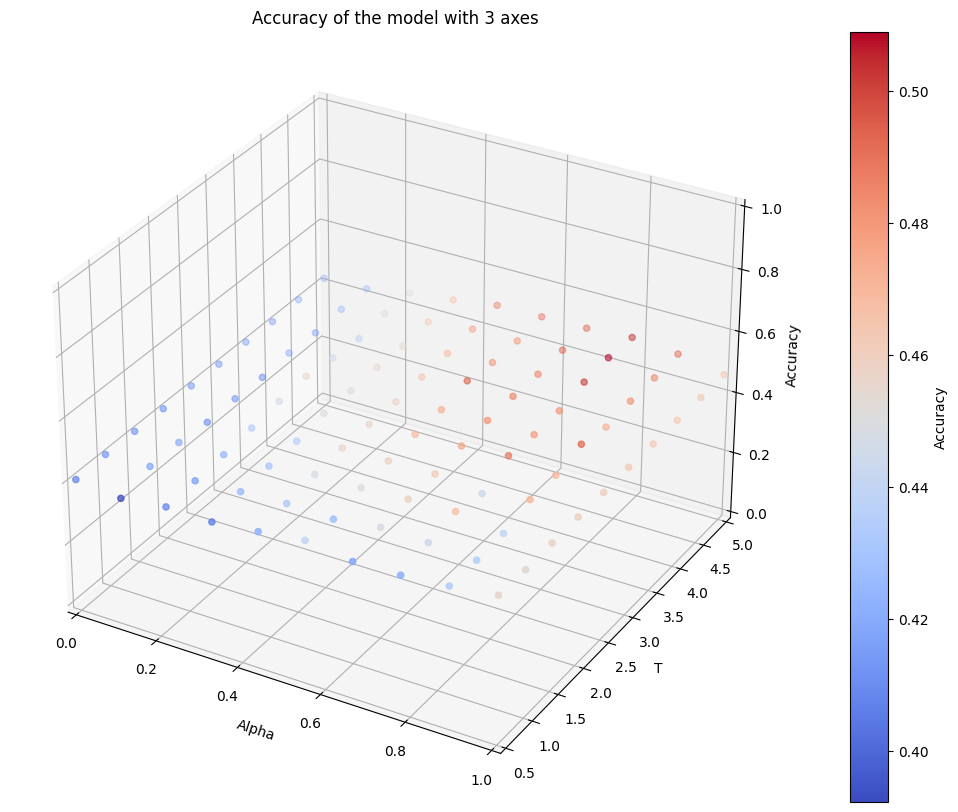

In [72]:
# separate the points into separate arrays for each dimension
alphas = np.array([point[0] for point in points])
Ts = np.array([point[1] for point in points])
accs = np.array([point[2] for point in points])

# create a 3D plot
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')

# plot the points as a scatter plot
sc = ax.scatter(alphas, Ts, accs, c=accs, cmap=plt.cm.get_cmap('coolwarm'))

# set the axis labels
ax.set_xlabel('Alpha')
ax.set_ylabel('T')
ax.set_zlabel('Accuracy')

# set the axis limits
ax.set_xlim([0, 1])
ax.set_ylim([0.5, 5])
ax.set_zlim([0, 1])

# add a colorbar to the plot
cbar = plt.colorbar(sc)
cbar.set_label('Accuracy')

plt.title('Accuracy of the model with 3 axes')
# show the plot
plt.show()

<ipython-input-74-afa50eed2104>:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


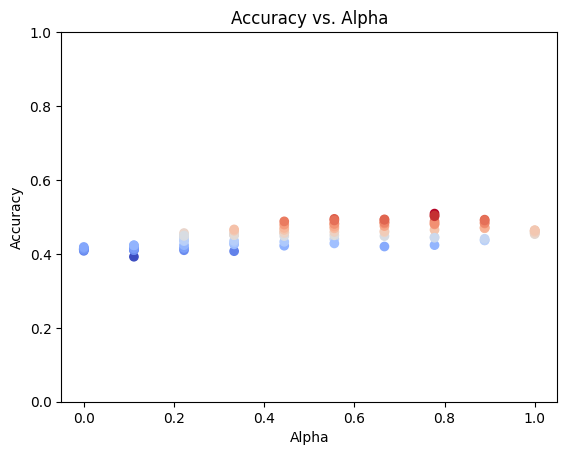

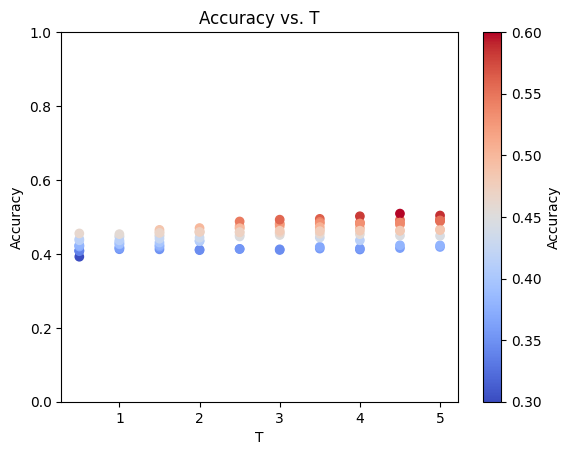

In [74]:
# create the first subplot for (Alpha, Accuracy)
fig, ax1 = plt.subplots()
ax1.scatter(alphas, accs, c=accs, cmap='coolwarm')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Accuracy vs. Alpha')

# create the second subplot for (T, Accuracy)
fig, ax2 = plt.subplots()
ax2.scatter(Ts, accs, c=accs, cmap='coolwarm')
ax2.set_xlabel('T')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])
ax2.set_title('Accuracy vs. T')

# add a colorbar to the subplots
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0.3, vmax=0.6))
sm._A = []
cbar = plt.colorbar(sm)
cbar.set_label('Accuracy')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# show the plots
plt.show()

## Conclusion

We didn't see strong dependency between accuracy of distilled model and hyperparameters (alpha and T).

May be it can be changed by more accurately choosing setup for pretraining and distillation